# Algorithmic Fairness, Accountability, and Ethics, Spring 2023

## Mandatory Assignment 1

Please use the following code to prepare the dataset.
 

In [1]:
# !pip install folktables
# !pip install hvplot

In [2]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data.sample(10_000), feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

In [56]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC # Too slow
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

import hvplot.pandas
import holoviews as hv

In [4]:
clf1 = make_pipeline(MinMaxScaler(), LogisticRegression())
clf2 = make_pipeline(MinMaxScaler(), RandomForestClassifier(max_depth=3))
clfs = [clf1, clf2]
train_group_masks = [group_train == 1, group_train == 2]
test_group_masks = [group_test == 1, group_test == 2]

In [5]:
for clf in clfs:
    clf.fit(X_train, y_train)

In [17]:
# df_whitebox_metric = pd.DataFrame([[0]*11], columns=["Accuracy","SP_1","SP_2","Eodd0_1","Eodd0_2","Eodd1_1","Eodd1_2","Eout0_1","Eout0_2","Eout1_1","Eout1_2"])
# df_blackbox_metric = pd.DataFrame([[0]*11], columns=["Accuracy","SP_1","SP_2","Eodd0_1","Eodd0_2","Eodd1_1","Eodd1_2","Eout0_1","Eout0_2","Eout1_1","Eout1_2"])
# df_boxes = [df_whitebox_metric, df_blackbox_metric]
df_metrics = pd.DataFrame([[0]*11]*2, index=["WhiteBox","BlackBox"],columns=["Accuracy","SP_1","SP_2","Eodd0_1","Eodd0_2","Eodd1_1","Eodd1_2","Eout0_1","Eout0_2","Eout1_1","Eout1_2"])
df_boxes = ["WhiteBox", "BlackBox"]

In [35]:
print("Baseline accuracy")
for i, clf in enumerate(clfs):
    Accuracy = round(clf.score(X_test,y_test),3)
    print(clf[1],"\n",Accuracy)
    df_metrics.loc[df_boxes[i],"Accuracy"]= Accuracy
    

Baseline accuracy
LogisticRegression() 
 0.749
RandomForestClassifier(max_depth=3) 
 0.76


In [ ]:
scores = [
    [clf.score(X_test[mask], y_test[mask]) for mask in test_group_masks] for clf in clfs
]
pd.DataFrame(
    scores, columns=["Group 1", "Group 2"], index=["WhiteBox", "BlackBox"]
).rename_axis("Baseline accuracy [%]").round(2)



In [38]:
positives = [
    [clf.predict(X_test[mask]).mean() for mask in test_group_masks] for clf in clfs
]
pd.DataFrame(
    positives, columns=["Group 1", "Group 2"], index=["WhiteBox", "BlackBox"]
).rename_axis("Baseline positive [%]").round(2)
df_metrics.loc["WhiteBox","SP_1"] = positives[0][0]
df_metrics.loc["WhiteBox","SP_2"] = positives[0][1]
df_metrics.loc["BlackBox","SP_1"] = positives[1][0]
df_metrics.loc["BlackBox","SP_2"] = positives[1][1]

In [47]:
clfs

[Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('logisticregression', LogisticRegression())]),
 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(max_depth=3))])]

In [49]:
def get_group_df(group, group_no,clf):
    prob = pd.Series(clf.predict_proba(X_train[group])[:, 1], name="prob")
    T = pd.Series(y_train[group], name="T")
    G = pd.Series([bool(group_no)] * len(T), name="G")
    return pd.concat([prob, G, T], axis=1)

for i, box in enumerate(df_boxes):
    
    df = pd.concat(
        [get_group_df(group, group_no,clfs[i]) for group_no, group in enumerate(train_group_masks)],)
    df["S"] = df["prob"] * 100 > 50
    #G is group
    #T is target
    #S is prediction/selection
    TP_group1 = len(df.query("T and S and ~G"))
    TPR_group1 = TP_group1/len(df.query("~G and T"))
    TP_group2 = len(df.query("T and S and G"))
    TPR_group2 = TP_group2/len(df.query("G and T"))
    df_metrics.loc[box,"Eodd0_1"] = TPR_group1
    df_metrics.loc[box,"Eodd0_2"] = TPR_group2
    FPR_group1 = len(df.query("~T and ~S and ~G"))/len(df.query("~G and ~T"))
    df_metrics.loc[box,"Eodd1_1"] = FPR_group1
    FPR_group1 = len(df.query("~T and ~S and G"))/len(df.query("G and ~T"))
    df_metrics.loc[box,"Eodd1_2"] = FPR_group1
    # Equalized outcome 0 is precision
    Precision_group1 = len(df.query("~G and T and S"))/len(df.query("~G and S"))
    df_metrics.loc[box,"Eout0_1"] = Precision_group1
    Precision_group2 = len(df.query("G and T and S"))/len(df.query("G and S"))
    df_metrics.loc[box,"Eout0_2"] = Precision_group2
    EOut1_group1 = len(df.query("~G and T and ~S"))/len(df.query("~G and ~S"))
    df_metrics.loc[box,"Eout1_1"] = EOut1_group1
    EOut1_group2 = len(df.query("G and T and ~S"))/len(df.query("G and ~S"))
    df_metrics.loc[box,"Eout1_2"] = EOut1_group2
    
    

Text(0, 0.5, 'Probability')

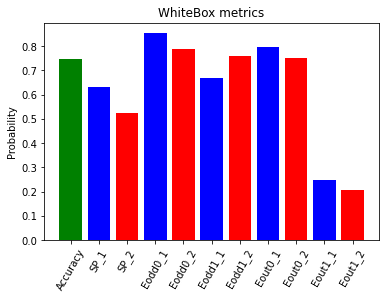

In [68]:
# df
colorlist=["g","b","r","b","r","b","r","b","r","b","r"]
plt.bar(df_metrics.columns,height=df_metrics.loc["WhiteBox"],color=colorlist)
plt.xticks(rotation=60);
plt.title("WhiteBox metrics")
plt.ylabel("Probability")


Text(0, 0.5, 'Probability')

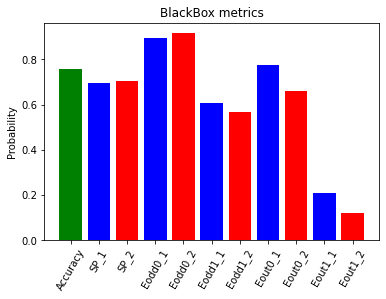

In [69]:
plt.bar(df_metrics.columns,height=df_metrics.loc["BlackBox"],color=colorlist)
plt.xticks(rotation=60);
plt.title("BlackBox metrics")
plt.ylabel("Probability")

In [ ]:
def ROC_curve(clf):

    def get_group_df(group, group_no):
        prob = pd.Series(clf.predict_proba(X_train[group])[:, 1], name="prob")
        T = pd.Series(y_train[group], name="T")
        G = pd.Series([bool(group_no)] * len(T), name="G")
        return pd.concat([prob, G, T], axis=1)


    df = pd.concat(
        [get_group_df(group, group_no) for group_no, group in enumerate(train_group_masks)],
    )

    ROC_g = []
    ROC_G = []
    for threshold in range(5, 100, 5):
        df["S"] = df["prob"] * 100 > threshold
        # TP_G = Count(S, G, T) / Count(G, T)
        # FP_G = Count(S, G, ~T) / Count(G, ~T)
        TP_g = len(df.query("S and ~G and T")) / len(df.query("~G and T"))
        FP_g = len(df.query("S and ~G and ~T")) / len(df.query("~G and ~T"))
        ROC_g.append([TP_g, FP_g, threshold])
        TP_G = len(df.query("S and G and T")) / len(df.query("G and T"))
        FP_G = len(df.query("S and G and ~T")) / len(df.query("G and ~T"))
        ROC_G.append([TP_G, FP_G, threshold])

        if threshold == 50:
            g_mid = [[TP_g, FP_g, 50]]
            G_mid = [[TP_G, FP_G, 50]]

    kwargs = dict(y='0', x='1', hover_cols=['2'], xlabel='False Positive Rate = Pr(S=1 | G=g, T=0)', ylabel='True Positive Rate = Pr(S=1 | G=g, T=1)')
    ROC_plot = pd.DataFrame(ROC_g).hvplot(**kwargs).relabel('G=1') * pd.DataFrame(ROC_G).hvplot(**kwargs).relabel('G=2')
    mids = pd.DataFrame(g_mid).hvplot.scatter(**kwargs) * pd.DataFrame(G_mid).hvplot.scatter(**kwargs)
    return ROC_plot * mids
plots = ROC_curve(clfs[0]).opts(title=str(clfs[0])) + ROC_curve(clfs[1]).opts(title=str(clfs[1]))
plots.cols(1)

# Creating statistical parity

In [ ]:
scores = []
for clf in clfs:
    preds = [clf.predict(X_test[mask]) for mask in test_group_masks]
    lowest_pred = min(pred.mean() for pred in preds)

    def statistical_parity(pred: np.array) -> np.array:
        ratio_delta = pred.mean() - lowest_pred
        n_remove = int(len(pred) * ratio_delta)
        remove_idx = np.random.choice(
            np.where(pred == 1)[0], size=n_remove, replace=False
        )
        pred[remove_idx] = 0
        return pred

    preds = [statistical_parity(pred) for pred in preds]
    scores.append([pred.mean() for pred in preds])

pd.DataFrame(
    scores, columns=["Group 1", "Group 2"], index=["WhiteBox", "BlackBox"]
).rename_axis("Parity positive [%]").round(2)

# Trying to have equalized odds under same threshold (fails)

In [ ]:
# ROC_g = []
# threshold = 61
# for p in range(0, 15, 1):
#     TP = []
#     FP = []
#     for _ in range(10):
#         n_random = int(len(df)*p/100)
#         df['S'] = df['prob']*100 > threshold
#         random_idx = np.random.choice(df.index, size=n_random, replace=False)
#         df.loc[random_idx, 'S'] = np.random.choice([True, False], size=n_random, replace=True)

#         # TP_G = Count(S, G, T) / Count(G, T)
#         # FP_G = Count(S, G, ~T) / Count(G, ~T)
#         TP.append(len(df.query('S and ~G and T')) / len(df.query('~G and T')))
#         FP.append(len(df.query('S and ~G and ~T')) / len(df.query('~G and ~T')))
#     ROC_g.append([sum(TP)/len(TP), sum(FP)/len(FP), p])
# random_plot = pd.DataFrame(ROC_g).hvplot(**kwargs).relabel('Randomized')
# ROC_plot * random_plot